In [118]:
import os
import re
#import ROOT
import hist
from hist import Hist
from hist.axis import IntCategory, Regular, StrCategory
import pickle
import mplhep as hep
from glob import glob
import numpy as np
import awkward as ak
from tabulate import tabulate
from IPython import embed
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares
hep.style.use("CMS")
print("iminuit version:", iminuit.__version__)
import itertools
from collections import defaultdict
import glob

iminuit version: 2.30.1


In [119]:
## Load the data_storage from the previous run

if os.path.exists("data_storage_DesyTau.pkl"):
    with open("data_storage_DesyTau.pkl", "rb") as file:
        data_storage_dict = pickle.load(file)
    # Convert to defaultdict (optional, if you need default values)
    data_storage = defaultdict(lambda: {"values": [], "err": [], "colour": None, "location": None})
    # Load the data and update it
    data_storage.update(data_storage_dict)
else:
    data_storage = defaultdict(lambda: {"values": [], "err": [], "colour": None, "location": None})
#data_storage

In [120]:
#process_axis.index(props["process"]) #used to be shift-index
process_axis

StrCategory(['h_ggf_htt_sm_prod_sm', 'wj'], growth=True, name='process')

✅ cpo: Sauvé INPUT/02_DesyTau_cf_0p3/MTT_MW_ggF/cpo/all_configs_hist__var_phi_cp_mu_a1_3pr_pv.pickle
✅ cpo: Sauvé INPUT/02_DesyTau_cf_0p3/MTT_MW_ggF/cpo/all_configs_hist__var_phi_cp_mu_a1_3pr_pv.pickle
✅ cpo: Sauvé INPUT/02_DesyTau_cf_0p3/MTT_MW_ggF/cpo/all_configs_hist__var_phi_cp_mu_a1_3pr_pv.pickle
✅ cpo: Sauvé INPUT/02_DesyTau_cf_0p3/MTT_MW_ggF/cpo/all_configs_hist__var_phi_cp_mu_a1_3pr_pv.pickle
✅ cpo: Sauvé INPUT/02_DesyTau_cf_0p3/MTT_MW_ggF/cpo/all_configs_hist__var_phi_cp_mu_a1_3pr_dp.pickle
✅ cpo: Sauvé INPUT/02_DesyTau_cf_0p3/MTT_MW_ggF/cpo/all_configs_hist__var_phi_cp_mu_a1_3pr_dp.pickle
✅ cpo: Sauvé INPUT/02_DesyTau_cf_0p3/MTT_MW_ggF/cpo/all_configs_hist__var_phi_cp_mu_a1_3pr_dp.pickle
✅ cpo: Sauvé INPUT/02_DesyTau_cf_0p3/MTT_MW_ggF/cpo/all_configs_hist__var_phi_cp_mu_a1_3pr_dp.pickle
✅ mm: Sauvé INPUT/02_DesyTau_cf_0p3/MTT_MW_ggF/mm/all_configs_hist__var_phi_cp_mu_a1_3pr_pv.pickle
✅ mm: Sauvé INPUT/02_DesyTau_cf_0p3/MTT_MW_ggF/mm/all_configs_hist__var_phi_cp_mu_a1_3pr_pv.p

KeyError: 'cp_even_vs_cp_odd'

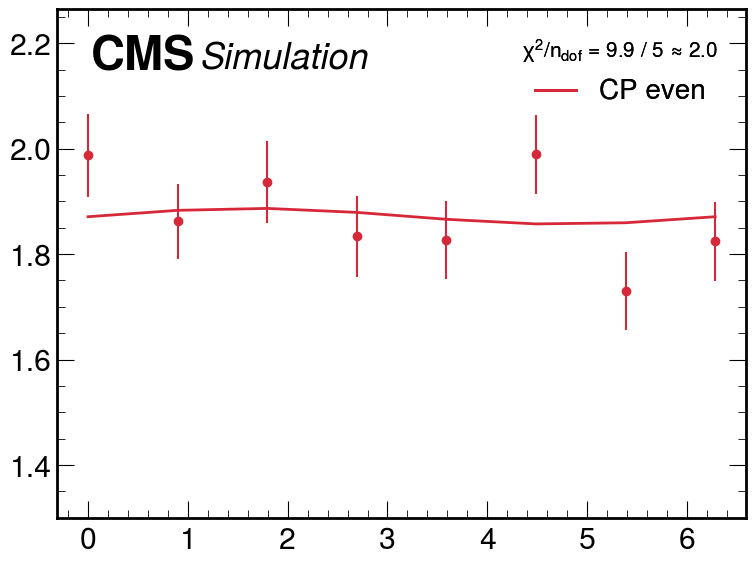

In [121]:
## Define the categories and tags
tags = ["pv", "dp"]


cat = r"$\mu a^{3p}_{1}$"

#chosen_category = "cat_mutau_sr"
chosen_category = "cat_mutau_sr__tau2a1_3pr"

## Combine the Pickle files if needed
#dir_name = "02_DesyTau_cf_0p3/control_plots_ggF"
#dir_name = "02_DesyTau_cf_0p3/control_plots_VBF"
#dir_name = "02_DesyTau_cf_0p3/MTT_MW_ggF"
#dir_name = "02_DesyTau_cf_0p3/MTT_MW_VBF"
#dir_name = "02_DesyTau_cf_0p3/control_gen_ggF"
#dir_name = "02_DesyTau_cf_0p3/control_gen_VBF"

dir_names = [ #"02_DesyTau_cf_0p3/control_plots_ggF",
#             "02_DesyTau_cf_0p3/control_plots_VBF",
             "02_DesyTau_cf_0p3/MTT_MW_ggF",
#             "02_DesyTau_cf_0p3/MTT_MW_VBF",
#             "02_DesyTau_cf_0p3/control_gen_ggF",
#             "02_DesyTau_cf_0p3/control_gen_VBF"
            ]

for dir_name in dir_names:

    if "VBF" in dir_name:
        base = 12000
    else:
        base = 11000 #=ggF
    
    shiftdict = {
        "cp_even": {"shift": 150, "colour": "#d62839", "location": "upper right", "linestyle": "solid"},
        "cp_odd": {"shift": 151, "colour": "#28348e", "location": "lower left", "linestyle": (0, (2, 2))},
        "cp_maxmix": {"shift": 0, "colour": "#2b663c", "location": "lower right", "linestyle":(0, (2, 1, 0.5, 1, 0.5, 1, 0.5, 1))},
    }

    # CP mapping depending on process name
    if "VBF" in dir_name:
        process_map = {
            "h_vbf_htt_sm": "cp_even",
            "h_vbf_htt_mm": "cp_maxmix",
            "h_vbf_htt_cpo": "cp_odd",
        }
        is_vbf = "VBF"
    elif "ggF" in dir_name:
        process_map = {
            "h_ggf_htt_sm_prod_sm": "cp_even",
            "h_ggf_htt_mm_prod_sm": "cp_maxmix",
            "h_ggf_htt_cpo_prod_sm": "cp_odd",
        }
        is_vbf = "ggF"
    else:
        process_map = {}  # for control or other categories
        is_vbf = "control"

    
    cp_map = {
        "sm": "cp_even",
        "cpo": "cp_odd",
        "mm": "cp_maxmix",
    }
    
    simpledict = {
        r"$\mu \pi$"     : "mupi",
        r"$\mu \rho$"    : "murho",
        r"$\mu a^{3p}_{1}$" : "mua13pr",
        r"$\mu \tau$" : "mutau",
        r"$\rho \rho 0j$" : "rhorho0j",
    }
    
    ## Combine the Pickle files if needed
    
    subdirs = [
        "cpo",
        "mm",
        "sm"
    ]
    
    base_dir = os.path.join("INPUT", dir_name)
    place_combined_pickels = os.path.join(base_dir, "combined_pickles")
    output_dir = os.path.join("OUTPUT", dir_name)
    os.makedirs(place_combined_pickels, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)
    
    
    #file_names = set(os.path.basename(f) for f in glob.glob(os.path.join(base_dir, subdirs[0], "*.pickle"))) # 4(configs)x2(methods) files
    for subdir in subdirs:
        folder = os.path.join(base_dir, subdir)

        for suffix in ["pv", "dp"]:
            # tous les fichiers *_pv.pickle (ou *_dp.pickle) du sous-dossier
            all_files = glob.glob(os.path.join(folder, f"*_{suffix}.pickle"))

            # Grouper par nom commun sans le préfixe (preee, postee, prebpix, postbpix)
            groups = {}
            for path in all_files:
                name = os.path.basename(path)
                # Ignore déjà les fichiers all_configs_...
                if name.startswith("all_configs_"):
                    continue
                # retirer le préfixe avant le 1er "_"
                common_name = name.split("_", 1)[1]  
                groups.setdefault(common_name, []).append(path)

            # Fusionner chaque groupe
                for common_name, file_list in groups.items():
                    combined = None
                    for fpath in file_list:
                        with open(fpath, "rb") as f:
                            hist = pickle.load(f)
                            if combined is None:
                                combined = hist.copy()
                            else:
                                combined += hist  # somme bin-à-bin

                    # Sauver le pickle combiné
                    output_path = os.path.join(folder, f"all_configs_{common_name}")
                    with open(output_path, "wb") as f:
                        pickle.dump(combined, f)
                    print(f"✅ {subdir}: Sauvé {output_path}")
                    
    # === NEU: Kombiniere alle CP-Histogramme (cpo, sm, mm) ===
    file_names = set(os.path.basename(f) for f in glob.glob(os.path.join(base_dir, subdirs[0], "all_configs_*.pickle")))

    for file_name in file_names:
        histograms_per_cp = {}

        # Load histograms from each subdir
        for subdir in subdirs:
            file_path = os.path.join(base_dir, subdir, file_name)
            print("Loading file:", file_path)
            
            if not os.path.exists(file_path):
                print(f"⚠️ Datei fehlt: {file_path}, skip")
                continue

            with open(file_path, 'rb') as f:
                hist = pickle.load(f)
                # Kategorie auswählen, falls nötig
                hist = hist[{"category": chosen_category}]

            # Extract histograms per process name
        
            histograms_per_cp[subdir] = hist

        #if not histograms_per_cp:
        #    continue

        #here11

        combined_output_path = os.path.join(place_combined_pickels, f"cp_all_{file_name}")
        if os.path.exists(combined_output_path):
            print(f"✅ Bereits vorhanden: {combined_output_path}, skip")
            continue

        # Combine histograms
        cp_keys = list(histograms_per_cp.keys())
        combined_hist = histograms_per_cp[cp_keys[0]].copy()
        for cp_key in cp_keys[1:]:
            combined_hist += histograms_per_cp[cp_key]

        with open(combined_output_path, 'wb') as f:
            pickle.dump(combined_hist, f)
        print(f"✅ Gespeichert: {combined_output_path}")


    
    
    ## Loop over the tags and categories, do the fitting and save the results
    for tag in tags:  # Loop over tags
        print(f"Processing tag: {tag}")
        file_list = glob.glob(f"{base_dir}/combined_pickles/cp_all_all_configs_hist__*.pickle", recursive=True)
        
        for file in file_list:
            print(f"Checking file: {file}, looking for tag: {tag}")
            if tag in file:
                print(f"Take file: {file}")
            if tag not in file:
                print(f"Skipping: {file}")
                continue
    
            if "control" in file and "gen" not in file:
                is_gen = "Reco"
            elif "control" in file and "gen" in file:
                is_gen = "Gen"
            elif "MTT" in base_dir and "pv" in tag:
                is_gen = "fastMTT"
            elif "MTT" in base_dir and "dp" in tag:
                print("is_gen = Reco_from_fastMTT : ", tag)
                is_gen = "Reco_from_fastMTT" #here10nov might be the error comming from
            else:
                is_gen = tag
                print("!file outside is_gen categories!")
    
            
            tag_kind = f"{tag} {is_gen}"
            print(f">>>---- Processing file : {file} --->>>")
            print(f">>>---- Tag & is_gen : {tag_kind}")
            fileptr = open(file, 'rb')
            data = pickle.load(fileptr)
            nbin = data.shape[2]
            fileptr.close()
    
            if not hasattr(data, 'axes'):
                print(f"Warning: 'axes' not found in {file}. Skipping...")
                continue
    
            axes = data.axes
            process_axis  = axes['process']
    
            cparray = {}
            for proc_name, cp_key in process_map.items():
                if proc_name not in process_axis:
                    print(f"⚠️ {proc_name} not found in process_axis")
                    continue
                idx = process_axis.index(proc_name)
                values = data[idx, :, :].values()
                errors = data[idx, :, :].variances() ** 0.5
                cparray[cp_key] = {
                    "values": values,
                    "errors": errors,
                    "colour": shiftdict[cp_key]["colour"],
                    "location": shiftdict[cp_key]["location"],
                    "linestyle": shiftdict[cp_key]["linestyle"],
                }
    
    
            def model(x, a, b, c):
                return a*np.cos(x+c) + b
    
            def fit(x, y, err=0.05, model=model):
                lsq = LeastSquares(x, y, err, model)
                m = Minuit(lsq, a=0.1, b=0.1, c=1.0)
                #m.scan(ncall=100)
                m.fixed = False
                m.migrad()  # finds minimum of least_squares function
                m.hesse()  # accurately computes uncertainties
                return m, err, m.values["a"], m.errors["a"], m.values["b"], m.errors["b"], m.values["c"]
    
            def comp_asymmetry(arr1, arr2):
                # https://github.com/Ksavva1021/TIDAL/blob/656f992ae056b3fed0061f2b3efb49905c39834d/CP_Tools/scripts/assymetry.py#L26
                return (1/arr1.size)*np.sum(np.abs((arr1-arr2)/(arr1+arr2)))
    
            def comp_asymmetry_error(arr1, arr2, err1, err2): #arr = array of values, err = array of errors
                # Terms for partial derivatives
                denom = arr1 + arr2
                term1 = err1 * np.abs((2 * arr2) / (denom**2))
                term2 = err2 * np.abs((2 * arr1) / (denom**2))
                # Propagate errors
                sigma_A = np.sqrt(np.sum(term1**2 + term2**2)) / arr1.size
                return sigma_A
    
            x = np.linspace(0., 2*np.pi, nbin)

                
            plt.figure(figsize=(8.9, 6.6))
            hep.cms.text("Simulation", loc=1)
            line_width = 2
            legend_line_width = line_width
    
            ## Initialise category in data_storage if not already there
            if cat not in data_storage:
                data_storage[cat] = {
                    f"{dir_name}": {},  # Initialise the tags key to store per-category tags
                }
            if dir_name not in data_storage[cat]:
                data_storage[cat][dir_name] = {}
            if tag_kind not in data_storage[cat][dir_name]:
                data_storage[cat][dir_name][tag_kind] = {}
    
            for hyp, shift_props in shiftdict.items():  # Loop over hypotheses
                if hyp not in cparray: #such that plot works also with less than all cp hypotheses
                    print(f"⚠️ {hyp} not found in cparray, skipping")
                    continue
                shift, colour, location, linestyle = shift_props["shift"], shift_props["colour"], shift_props["location"], shift_props["linestyle"]
                #print("hyp : ", hyp, "shift_props :", shift_props) #hyp = shift
    
                hypothesis_zip = cparray[hyp]  # gives per hypothesis: {'values': array, 'errors': array, '...': 'black', 'location': '...'}
                hypothesis_fit_vals, hypothesis_fit_errs = np.ravel(hypothesis_zip["values"]), np.ravel(hypothesis_zip["errors"])
    
                # Fit the Hypothesis
                m, err, a, sigma_a, b, sigma_b, c = fit(x, hypothesis_fit_vals, hypothesis_fit_errs)
    
    
                if tag_kind not in data_storage[cat][dir_name]:  
                    data_storage[cat][dir_name][tag_kind] = {}  # Initialise tag_kind in [tag_kind] if not already there
    
                data_storage[cat][dir_name][tag_kind][hyp] = {  # Directly use hypothesis name
                    "values": np.array(hypothesis_fit_vals), # hypothesis_fit_vals.tolist(),
                    "err": err,
                    "colour": colour,
                    "location": location,
                    #"m": m,
                }
    
    
                # Plot the results
                plt.errorbar(x, hypothesis_fit_vals, hypothesis_fit_errs, fmt="o", color=colour)
                fit_curve = model(x, *m.values)
                plt.plot(x, fit_curve, color=colour, linestyle=linestyle, linewidth=line_width)
                fit_info = [
                    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} ≈ {m.fmin.reduced_chi2:.1f}",
                ]
                legend_handle = Line2D([0], [0], color=colour, linestyle=linestyle, linewidth=legend_line_width, label=f"CP {hyp[3:]}")
                legend = plt.legend(handles=[legend_handle], title="\n".join(fit_info), frameon=False, loc=location, fontsize=20, title_fontsize=15)
                plt.gca().add_artist(legend)
    
                fit_y_min = np.min(fit_curve)
                fit_y_max = np.max(fit_curve)
                y_min = fit_y_min - 0.3 * fit_y_min
                y_max = fit_y_max + 0.2 * fit_y_max
                plt.ylim(y_min, y_max)

            # Alle vorhandenen Hypothesen in cparray
            existing_hyps = list(cparray.keys())
    
            #for category1, category2 in itertools.combinations(shiftdict.keys(), 2):  # Loop over pairs of hypotheses (asymmetry calculations)
            for category1, category2 in itertools.combinations(existing_hyps, 2):  # Loop over pairs of existing hypotheses (asymmetry calculations)
                hypothesis1 = np.ravel(cparray[category1]["values"])
                hypothesis2 = np.ravel(cparray[category2]["values"])
                error1 = np.ravel(cparray[category1]["errors"])
                error2 = np.ravel(cparray[category2]["errors"])
    
                asymmetry = comp_asymmetry(hypothesis1, hypothesis2)
                asymmetry_error = comp_asymmetry_error(hypothesis1, hypothesis2, error1, error2)
    
                combo_name = f"{category1}_vs_{category2}"
                print("combo_name : ", combo_name)
    
                if combo_name not in data_storage[cat][dir_name][tag_kind]:
                    data_storage[cat][dir_name][tag_kind][combo_name] = {}  # Initialize combo_name under tag_kind if not already there
    
                # Store the asymmetry result for this category and tag_kind
                data_storage[cat][dir_name][tag_kind][combo_name]["asymmetry_val"] = asymmetry
                data_storage[cat][dir_name][tag_kind][combo_name]["asymmetry_error"] = asymmetry_error
    
    
            # Save the final plot
            asymmetry_val_even_odd = data_storage[cat][dir_name][tag_kind]["cp_even_vs_cp_odd"]["asymmetry_val"]
            asymmetry_error_even_odd = data_storage[cat][dir_name][tag_kind]["cp_even_vs_cp_odd"]["asymmetry_error"]
            asymmetry_val_even_odd_rounded = round(asymmetry_val_even_odd, 3)
            asymmetry_error_even_odd_rounded = round(asymmetry_error_even_odd, 3)
    
            x_label = r"$\Phi_{CP}$" + f" ({tag_kind})"
            #if is_gen == "Gen":
            #    x_label += " (Gen)"
    
            plt.xlabel(x_label)
            plt.ylabel("a.u")
            plt.title(f"($A_{{even,odd}}$ = {asymmetry_val_even_odd_rounded}$\\,\\pm\\,${asymmetry_error_even_odd_rounded})", fontsize=25, loc='center')
            plt.tight_layout()
            plt.savefig(f"{output_dir}/{tag_kind}_{is_vbf}.pdf", dpi=300)
            plt.show()
                

In [124]:
list(test_hist.axes[0])

['incl',
 'cat_mutau',
 'cat_mutau_sr',
 'cat_mutau_dr_den_wj',
 'cat_mutau_dr_den_wj_w_ff',
 'cat_mutau_dr_num_qcd',
 'cat_mutau_dr_den_qcd',
 'cat_mutau_dr_den_qcd_w_ff',
 'cat_mutau_ar_yields',
 'cat_mutau_ar_wj',
 'cat_mutau_ar_qcd',
 'cat_mutau_abcd_ar',
 'cat_mutau_sr_no_mt',
 'cat_mutau_abcd_ar_no_mt',
 'cat_mutau_sr__jet_fakes',
 'cat_mutau_sr__prompt',
 'cat_mutau_dr_den_wj__jet_fakes',
 'cat_mutau_dr_den_wj__prompt',
 'cat_mutau_dr_den_wj_w_ff__jet_fakes',
 'cat_mutau_dr_den_wj_w_ff__prompt',
 'cat_mutau_dr_num_qcd__prompt',
 'cat_mutau_dr_den_qcd__jet_fakes',
 'cat_mutau_dr_den_qcd__prompt',
 'cat_mutau_dr_den_qcd_w_ff__jet_fakes',
 'cat_mutau_dr_den_qcd_w_ff__prompt',
 'cat_mutau_ar_yields__jet_fakes',
 'cat_mutau_ar_yields__prompt',
 'cat_mutau_ar_wj__jet_fakes',
 'cat_mutau_ar_wj__prompt',
 'cat_mutau_ar_qcd__jet_fakes',
 'cat_mutau_ar_qcd__prompt',
 'cat_mutau_abcd_ar__prompt',
 'cat_mutau_sr_no_mt__jet_fakes',
 'cat_mutau_sr_no_mt__prompt',
 'cat_mutau_abcd_ar_no_mt__pr

In [125]:
def print_nested_keys(d, prefix=""):
    if isinstance(d, dict):
        for key, value in d.items():
            new_prefix = f"{prefix} -> {key}" if prefix else key
            print(new_prefix)
            print_nested_keys(value, new_prefix)

print_nested_keys(data_storage)

$\mu a^{3p}_{1}$
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_even
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_even -> values
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_even -> err
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_even -> colour
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_even -> location
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_odd
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_odd -> values
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_odd -> err
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_odd -> colour
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_odd -> location
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_maxmix
$\mu a^{3p}_{1}$ -> 01_DesyTau/control_plots -> pv Reco -> cp_maxmix -

# Compare the asymmetries + errors

In [126]:
colour_palette = ["#d62839", "#28348e", "#2b663c"]

def compare_asymmetries_pv(data_storage, selected_cats=None, selected_datasets=None, selected_tags=None, selected_keys=None):
    if selected_cats is None:
        selected_cats = list(data_storage.keys())
    if selected_datasets is None:
        selected_datasets = [ds for cat in selected_cats for ds in data_storage[cat].keys()]
    if selected_keys is None:
        selected_keys = [key for cat in selected_cats for ds in selected_datasets for tag in selected_tags for key in data_storage[cat][ds].get(tag, {}).keys()]

    print("selected_cats", selected_cats)
    print("selected_datasets:", selected_datasets)
    print("selected_tags", selected_tags)
    print("selected_keys", selected_keys)

    used_tags = {}
    for tag in selected_tags:
        if "Gen" in tag:
            #used_tags[tag] = r"full $p_T^{\tau}$ (Gen)"
            used_tags[tag] = r"gen $p_T^{\tau}$"
        elif "Reco" in tag:
            used_tags[tag] = r"visible $p_T^{\tau}$"
        elif "fastMTT" in tag:
            used_tags[tag] = r"fastMTT $p_T^{\tau}$"
        else:
            used_tags[tag] = tag

    info_text = []
    
    if len(selected_cats) == 1:
        if selected_cats[0] == '$\\mu a^{3p}_{1}$':
            info_text.append(r"Category $\mu a^{3p}$")
        else:
            info_text.append(f"Category : {selected_cats[0]}")
    if len(selected_datasets) == 1:
        info_text.append(f"Version : {selected_datasets[0]}")
    if len(selected_tags) == 1:
        info_text.append(f"Method : {selected_tags[0]}")
    if len(selected_keys) == 1:
        info_text.append(f"Asymmetry of : {selected_keys[0]}")

    # Replace _ with spaces
    info_text = "\n".join(line.replace("_", " ").replace("cp", "CP") for line in info_text) if info_text else None

    asymmetry_values = []
    asymmetry_errors = []
    labels = []
    colours = []
    dir_names = []  # <--- New list to store dir_name

    colour_map = {dir_name: colour_palette[i % len(colour_palette)] for i, dir_name in enumerate(selected_datasets)}
    legend_handles = {}

    for cat in selected_cats:
        if cat not in data_storage:
            continue

        for dir_name in selected_datasets:
            print("dir_name 1) : ", dir_name)
            if dir_name not in data_storage[cat]:
                continue
            colour = colour_map[dir_name]
            if dir_name not in legend_handles:
                legend_handles[dir_name] = plt.Line2D([0], [0], marker='o', color=colour, linestyle='None', label=dir_name)

            available_tags = [tag for tag in selected_tags if tag in data_storage[cat][dir_name]]

            for tag in available_tags:
                for key in selected_keys:
                    if key in data_storage[cat][dir_name][tag]:
                        data_entry = data_storage[cat][dir_name][tag][key]

                        if "_vs_" in key and "asymmetry_val" in data_entry and "asymmetry_error" in data_entry:
                            asymmetry_values.append(data_entry["asymmetry_val"])
                            asymmetry_errors.append(data_entry["asymmetry_error"])
                            dir_names.append(dir_name)  # <--- store dir_name as well

                            label_parts = []
                            if len(selected_cats) > 1:
                                label_parts.append(cat)
                            if len(selected_tags) > 1:
                                label_parts.append(tag)
                            if len(selected_keys) > 1:
                                label_parts.append(key)

                            labels.append(" - ".join(label_parts))
                            colours.append(colour)


    asymmetry_values = np.array(asymmetry_values)
    asymmetry_errors = np.array(asymmetry_errors)

    plt.figure(figsize=(7.7, 5.5))
    hep.cms.text("Private work", loc=0)

    unique_labels = list(dict.fromkeys(labels))
    label_to_xpos = {label: i for i, label in enumerate(unique_labels)}
    # Make sure that all lists are of the same length
    assert len(labels) == len(asymmetry_values) == len(asymmetry_errors) == len(dir_names)

    max_values = {}
    max_errors = {}
    max_values_vbf = {}
    max_errors_vbf = {}

    # Use dir_names to correctly assign ggF and VBF
    for label, value, error, dir_name in zip(labels, asymmetry_values, asymmetry_errors, dir_names):
        print("dir_name : ", dir_name)
        if "VBF" in dir_name:  # if VBF-Dataset
            print(f"VBF erkannt: {dir_name}, label: {label}, value: {value}")
            if label not in max_values_vbf or value > max_values_vbf[label]:
                max_values_vbf[label] = value
                max_errors_vbf[label] = error
        else:  # if ggF-Dataset
            print(f"ggF erkannt: {dir_name}, label: {label}, value: {value}")

            if label not in max_values or value > max_values[label]:
                max_values[label] = value
                max_errors[label] = error
    filtered_labels = list(set(max_values.keys()) | set(max_values_vbf.keys()))
    print("filtered_labels: ",filtered_labels)
    filtered_values = [max_values.get(label, 0) for label in filtered_labels]
    filtered_errors = [max_errors.get(label, 0) for label in filtered_labels]

    filtered_values_vbf = [max_values_vbf.get(label, 0) for label in filtered_labels]
    filtered_errors_vbf = [max_errors_vbf.get(label, 0) for label in filtered_labels]

    filtered_x_positions = [label_to_xpos[label] for label in filtered_labels]
    
    width = 0.19
    gap = 0.02
    
    # Plot bars for ggF
    plt.bar(filtered_x_positions, filtered_values, yerr=filtered_errors, width=width, label="ggF", color=colour_palette[0], capsize=5)
    # Plot bars for VBF slightly shifted to the right
    plt.bar([x + width + gap for x in filtered_x_positions], filtered_values_vbf, yerr=filtered_errors_vbf, width=width, label="VBF", color=colour_palette[1], capsize=5)

    # Labels, legend, and formatting
    plt.legend()

    gen_max = max([val for lbl, val in zip(labels, asymmetry_values) if lbl == "pv Gen"]) #here
    gen_max_error = next(err for lbl, val, err in zip(labels, asymmetry_values, asymmetry_errors) if lbl == "pv Gen") #here

    for label, max_val in max_values.items():
        max_err = max_errors[label]
        x_pos = label_to_xpos[label]

        percent = 100 if label == "pv Gen" else (max_val / gen_max) * 100 #here
        percent_err = percent * np.sqrt((max_err / max_val) ** 2 + (gen_max_error / gen_max) ** 2)

        ## Percentages as text for 1 prod channel
        #plt.text(x_pos, max_val + 0.015, f"\n\n{percent:.1f} ± {percent_err:.1f}%", ha="center", fontsize=10, color="black")

    if asymmetry_values.size > 0:
        A_y_min = np.min(asymmetry_values)
        A_y_max = np.max(asymmetry_values)
        y_max = A_y_max + 0.4 * A_y_max
        plt.ylim(0, y_max)

    mapped_labels = [used_tags.get(label, label) for label in filtered_labels]
    #plt.xticks(ticks=filtered_x_positions, labels=mapped_labels, rotation=45)
    plt.xticks(ticks=[x + (width / 2) + (gap / 2) for x in filtered_x_positions], labels=mapped_labels, rotation=45)


    plt.margins(x=0.1)
    plt.ylabel("Asymmetry")
    #plt.title("Comparison of Asymmetries", pad=45)

    if info_text:
        plt.annotate(info_text, xy=(0.05, 0.83), xycoords="axes fraction", fontsize=14,
                     bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    
    plt.grid()
    plt.savefig("OUTPUT/Asymmetry_DesyTau_PV.pdf", dpi=300, bbox_inches='tight')
    plt.show()



selected_cats ['$\\mu a^{3p}_{1}$']
selected_datasets: ['02_DesyTau_cf_0p3/control_plots_VBF', '02_DesyTau_cf_0p3/control_plots', '02_DesyTau_cf_0p3/MTT_MW_ggF', '02_DesyTau_cf_0p3/MTT_MW_VBF', '02_DesyTau_cf_0p3/control_gen_ggF', '02_DesyTau_cf_0p3/control_gen_VBF']
selected_tags ['pv Gen', 'pv Reco', 'pv fastMTT']
selected_keys ['cp_even_vs_cp_odd']
dir_name 1) :  02_DesyTau_cf_0p3/control_plots_VBF
dir_name 1) :  02_DesyTau_cf_0p3/control_plots
dir_name 1) :  02_DesyTau_cf_0p3/MTT_MW_ggF
dir_name 1) :  02_DesyTau_cf_0p3/MTT_MW_VBF
dir_name 1) :  02_DesyTau_cf_0p3/control_gen_ggF
dir_name 1) :  02_DesyTau_cf_0p3/control_gen_VBF
filtered_labels:  []


ValueError: max() iterable argument is empty

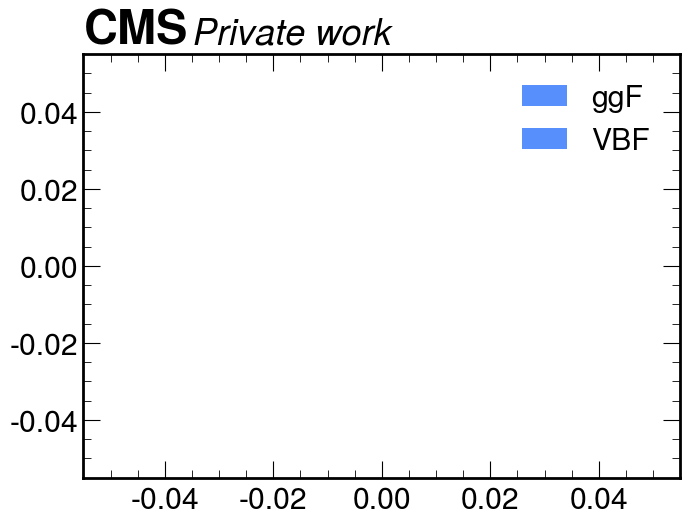

In [127]:
compare_asymmetries_pv(
    data_storage,
    selected_cats=['$\\mu a^{3p}_{1}$'],
    selected_datasets=["02_DesyTau_cf_0p3/control_plots_VBF", "02_DesyTau_cf_0p3/control_plots", "02_DesyTau_cf_0p3/MTT_MW_ggF", "02_DesyTau_cf_0p3/MTT_MW_VBF", "02_DesyTau_cf_0p3/control_gen_ggF", "02_DesyTau_cf_0p3/control_gen_VBF"],
    selected_tags=["pv Gen", "pv Reco", "pv fastMTT"],
    selected_keys=["cp_even_vs_cp_odd"]
)


In [25]:
# Before saving: convert defaultdict to dict
data_storage_dict = {k: dict(v) for k, v in data_storage.items()}

# Save data_storage to YAML
with open("data_storage_DesyTau.pkl", "wb") as file:
    pickle.dump(data_storage_dict, file) 


In [26]:
colour_palette = ["#d62839", "#28348e", "#2b663c"]

def compare_asymmetries_dp(data_storage, selected_cats=None, selected_datasets=None, selected_tags=None, selected_keys=None):
    if selected_cats is None:
        selected_cats = list(data_storage.keys())
    if selected_datasets is None:
        selected_datasets = [ds for cat in selected_cats for ds in data_storage[cat].keys()]
    if selected_keys is None:
        selected_keys = [key for cat in selected_cats for ds in selected_datasets for tag in selected_tags for key in data_storage[cat][ds].get(tag, {}).keys()]

    print("selected_cats", selected_cats)
    print("selected_datasets:", selected_datasets)
    print("selected_tags", selected_tags)
    print("selected_keys", selected_keys)

    used_tags = {}
    for tag in selected_tags:
        if "Gen" in tag:
            #used_tags[tag] = r"full $p_T^{\tau}$ (Gen)"
            used_tags[tag] = r"gen $p_T^{\tau}$"
        elif "Reco" in tag:
            used_tags[tag] = r"visible $p_T^{\tau}$"
        elif "fastMTT" in tag:
            used_tags[tag] = r"fastMTT $p_T^{\tau}$"
        else:
            used_tags[tag] = tag

    info_text = []
    
    if len(selected_cats) == 1:
        if selected_cats[0] == '$\\mu a^{3p}_{1}$':
            info_text.append(r"Category $\mu a^{3p}$")
        else:
            info_text.append(f"Category : {selected_cats[0]}")
    if len(selected_datasets) == 1:
        info_text.append(f"Version : {selected_datasets[0]}")
    if len(selected_tags) == 1:
        info_text.append(f"Method : {selected_tags[0]}")
    if len(selected_keys) == 1:
        info_text.append(f"Asymmetry of : {selected_keys[0]}")

    # Replace _ with spaces
    info_text = "\n".join(line.replace("_", " ").replace("cp", "CP") for line in info_text) if info_text else None

    asymmetry_values = []
    asymmetry_errors = []
    labels = []
    colours = []
    dir_names = []  # <--- New list to store dir_name

    colour_map = {dir_name: colour_palette[i % len(colour_palette)] for i, dir_name in enumerate(selected_datasets)}
    legend_handles = {}

    for cat in selected_cats:
        if cat not in data_storage:
            continue

        for dir_name in selected_datasets:
            print("dir_name 1) : ", dir_name)
            if dir_name not in data_storage[cat]:
                continue
            colour = colour_map[dir_name]
            if dir_name not in legend_handles:
                legend_handles[dir_name] = plt.Line2D([0], [0], marker='o', color=colour, linestyle='None', label=dir_name)

            available_tags = [tag for tag in selected_tags if tag in data_storage[cat][dir_name]]

            for tag in available_tags:
                for key in selected_keys:
                    if key in data_storage[cat][dir_name][tag]:
                        data_entry = data_storage[cat][dir_name][tag][key]

                        if "_vs_" in key and "asymmetry_val" in data_entry and "asymmetry_error" in data_entry:
                            asymmetry_values.append(data_entry["asymmetry_val"])
                            asymmetry_errors.append(data_entry["asymmetry_error"])
                            dir_names.append(dir_name)  # <--- store dir_name as well

                            label_parts = []
                            if len(selected_cats) > 1:
                                label_parts.append(cat)
                            if len(selected_tags) > 1:
                                label_parts.append(tag)
                            if len(selected_keys) > 1:
                                label_parts.append(key)

                            labels.append(" - ".join(label_parts))
                            colours.append(colour)


    asymmetry_values = np.array(asymmetry_values)
    asymmetry_errors = np.array(asymmetry_errors)

    #plt.figure(figsize=(7.7, 5.5))
    plt.figure(figsize=(7.7, 6.6))
    hep.cms.text("Private work", loc=0)

    unique_labels = list(dict.fromkeys(labels))
    label_to_xpos = {label: i for i, label in enumerate(unique_labels)}
    # Make sure that all lists are of the same length
    assert len(labels) == len(asymmetry_values) == len(asymmetry_errors) == len(dir_names)

    max_values = {}
    max_errors = {}
    max_values_vbf = {}
    max_errors_vbf = {}

    # Use dir_names to correctly assign ggF and VBF
    for label, value, error, dir_name in zip(labels, asymmetry_values, asymmetry_errors, dir_names):
        print("dir_name : ", dir_name)
        if "VBF" in dir_name:  # if VBF-Dataset
            print(f"VBF erkannt: {dir_name}, label: {label}, value: {value}")
            if label not in max_values_vbf or value > max_values_vbf[label]:
                max_values_vbf[label] = value
                max_errors_vbf[label] = error
        else:  # if ggF-Dataset
            print(f"ggF erkannt: {dir_name}, label: {label}, value: {value}")
        
            if label not in max_values or value > max_values[label]:
                max_values[label] = value
                max_errors[label] = error
    filtered_labels = list(set(max_values.keys()) | set(max_values_vbf.keys()))
    print("filtered_labels: ",filtered_labels)
    filtered_values = [max_values.get(label, 0) for label in filtered_labels]
    filtered_errors = [max_errors.get(label, 0) for label in filtered_labels]

    filtered_values_vbf = [max_values_vbf.get(label, 0) for label in filtered_labels]
    filtered_errors_vbf = [max_errors_vbf.get(label, 0) for label in filtered_labels]

    filtered_x_positions = [label_to_xpos[label] for label in filtered_labels]
    
    width = 0.19
    gap = 0.02
    
    # Plot bars for ggF
    plt.bar(filtered_x_positions, filtered_values, yerr=filtered_errors, width=width, label="ggF", color=colour_palette[0], capsize=5)
    # Plot bars for VBF slightly shifted to the right
    plt.bar([x + width + gap for x in filtered_x_positions], filtered_values_vbf, yerr=filtered_errors_vbf, width=width, label="VBF", color=colour_palette[1], capsize=5)

    # Labels, legend, and formatting
    plt.legend()

    
    # Maximum value and error for GGF
    print("labels : ", labels)
    print("dir_names : ", dir_names)
    print("asymmetry_values : ", asymmetry_values)

    #gen_max = max([val for lbl, val in zip(labels, asymmetry_values) if lbl == "dp Gen"]) #here
    #gen_max_error = next(err for lbl, val, err in zip(labels, asymmetry_values, asymmetry_errors) if lbl == "dp Gen") #here

    gen_max_ggf = max(
        val for lbl, dir_name, val in zip(labels, dir_names, asymmetry_values)
        if lbl == "dp Gen" and "ggf" in dir_name.lower()
    )
    
    gen_max_error_ggf = next(
        err for lbl, dir_name, err in zip(labels, dir_names, asymmetry_errors)
        if lbl == "dp Gen" and "ggf" in dir_name.lower()
    )
    
    # Maximum value and error for VBF
    gen_max_vbf = max(
        val for lbl, dir_name, val in zip(labels, dir_names, asymmetry_values)
        if lbl == "dp Gen" and "vbf" in dir_name.lower()
    )
    
    gen_max_error_vbf = next(
        err for lbl, dir_name, val, err in zip(labels, dir_names, asymmetry_values, asymmetry_errors)
        if lbl == "dp Gen" and "vbf" in dir_name.lower()
    )

    for lbl, dir_name, val in zip(labels, dir_names, asymmetry_values):
        print(f"gen_max_ggf: {gen_max_ggf}, lbl: {lbl}, dir_name: {dir_name}, val: {val} ")
        print(f"gen_max_vbf: {gen_max_vbf}, lbl: {lbl}, dir_name: {dir_name}, val: {val} ")


    # First: labels on top of ggF bars (left bars)
    for label in max_values:
        max_val = max_values[label]
        max_err = max_errors[label]
        x_pos = label_to_xpos[label]
    
        # Calculate percentage for ggF: it should be less than 100 if reco is smaller than gen
        percent = 100 if label == "dp Gen" else (max_val / gen_max_ggf) * 100
        percent_err = percent * np.sqrt((max_err / max_val) ** 2 + (gen_max_error_ggf / gen_max_ggf) ** 2)
    
        # Slightly to the left (aligned with ggF bar)
        #plt.text(x_pos - 0.02, max_val + 0.0075, f"{percent:.1f} ± {percent_err:.1f}%", ha="center", fontsize=10, color=colour_palette[0], zorder=10)
    
        print(f"VBF max_val: {max_val}, gen_max_ggf: {gen_max_ggf}, percent: {percent}, percent_error: {percent_err}")
    
    # Second: labels on top of VBF bars (right bars)
    for label in max_values_vbf:
        max_val = max_values_vbf[label]
        max_err = max_errors_vbf[label]
        x_pos = label_to_xpos[label] + width + gap
    
        # Calculate percentage for VBF: it should be more than 100 if reco is larger than gen
        percent = 100 if label == "dp Gen" else (max_val / gen_max_vbf) * 100
        percent_err = percent * np.sqrt((max_err / max_val) ** 2 + (gen_max_error_vbf / gen_max_vbf) ** 2)
    
        # Slightly to the right (aligned with VBF bar)
        #plt.text(x_pos + 0.02, max_val + 0.01, f"{percent:.1f} ± {percent_err:.1f}%", ha="center", fontsize=10, color=colour_palette[1], zorder=10)
    
        print(f"VBF max_val: {max_val}, gen_max_vbf: {gen_max_vbf}, percent: {percent}, percent_error: {percent_err}")


    


    if asymmetry_values.size > 0:
        A_y_min = np.min(asymmetry_values)
        A_y_max = np.max(asymmetry_values)
        y_max = A_y_max + 0.4 * A_y_max
        plt.ylim(0, y_max)

    mapped_labels = [used_tags.get(label, label) for label in filtered_labels]
    #plt.xticks(ticks=filtered_x_positions, labels=mapped_labels, rotation=45)
    plt.xticks(ticks=[x + (width / 2) + (gap / 2) for x in filtered_x_positions], labels=mapped_labels, rotation=45)


    plt.margins(x=0.1)
    plt.ylabel("Asymmetry")
    #plt.title("Comparison of Asymmetries", pad=45)

    if info_text:
        plt.annotate(info_text, xy=(0.05, 0.86), xycoords="axes fraction", fontsize=14,
                     bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")) #xy=(0.05, 0.83)
    
    plt.grid()
    plt.savefig("OUTPUT/Asymmetry_DesyTau_DP.pdf", dpi=300, bbox_inches='tight')
    plt.show()



selected_cats ['$\\mu a^{3p}_{1}$']
selected_datasets: ['01_DesyTau/control_plots', '01_DesyTau/wp_tight_MTT_MW_ggF', '01_DesyTau/wp_tight_MTT_MW_VBF', '01_DesyTau/control_gen_ggF', '01_DesyTau/control_gen_VBF']
selected_tags ['dp Gen', 'dp Reco']
selected_keys ['cp_even_vs_cp_odd']
dir_name 1) :  01_DesyTau/control_plots
dir_name 1) :  01_DesyTau/wp_tight_MTT_MW_ggF
dir_name 1) :  01_DesyTau/wp_tight_MTT_MW_VBF
dir_name 1) :  01_DesyTau/control_gen_ggF
dir_name 1) :  01_DesyTau/control_gen_VBF
dir_name :  01_DesyTau/control_plots
ggF erkannt: 01_DesyTau/control_plots, label: dp Reco, value: 0.06852073269197921
dir_name :  01_DesyTau/wp_tight_MTT_MW_ggF
ggF erkannt: 01_DesyTau/wp_tight_MTT_MW_ggF, label: dp Reco, value: 0.05867712671191201
dir_name :  01_DesyTau/wp_tight_MTT_MW_VBF
VBF erkannt: 01_DesyTau/wp_tight_MTT_MW_VBF, label: dp Reco, value: 0.06258443036954543
dir_name :  01_DesyTau/control_gen_ggF
ggF erkannt: 01_DesyTau/control_gen_ggF, label: dp Gen, value: 0.059056775360512

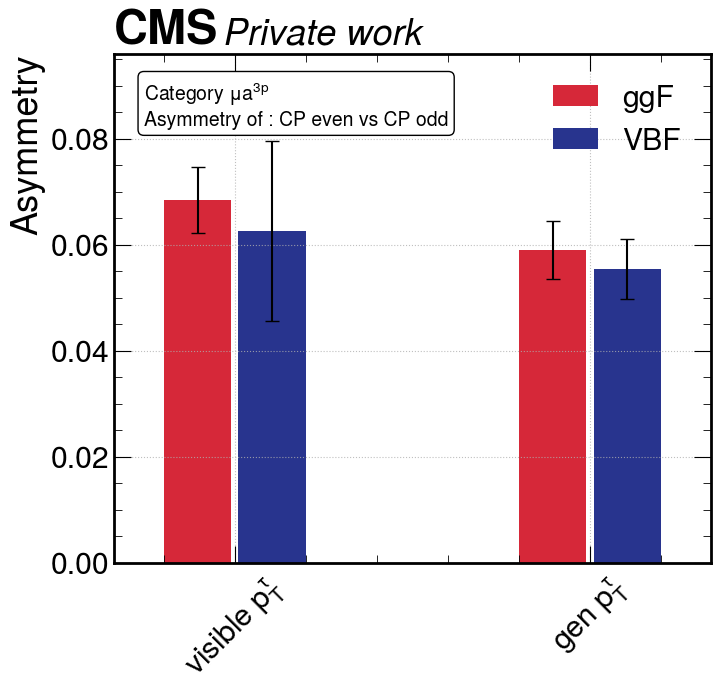

In [27]:
compare_asymmetries_dp(
    data_storage,
    selected_cats=['$\\mu a^{3p}_{1}$'],
    selected_datasets=["02_DesyTau_cf_0p3/control_plots", "02_DesyTau_cf_0p3/wp_tight_MTT_MW_ggF", "02_DesyTau_cf_0p3/wp_tight_MTT_MW_VBF", "02_DesyTau_cf_0p3/control_gen_ggF", "02_DesyTau_cf_0p3/control_gen_VBF"],
    selected_tags=["dp Gen", "dp Reco"],
    selected_keys=["cp_even_vs_cp_odd"]
)

In [ ]:
## Define the categories and tags
tags = ["pv", "dp"]


cat = r"$\mu a^{3p}_{1}$"

#chosen_category = "cat_mutau_sr"
chosen_category = "cat_mutau_sr__tau2a1_3pr"

## Combine the Pickle files if needed
#dir_name = "02_DesyTau_cf_0p3/control_plots_ggF"
#dir_name = "02_DesyTau_cf_0p3/control_plots_VBF"
#dir_name = "02_DesyTau_cf_0p3/MTT_MW_ggF"
#dir_name = "02_DesyTau_cf_0p3/MTT_MW_VBF"
#dir_name = "02_DesyTau_cf_0p3/control_gen_ggF"
#dir_name = "02_DesyTau_cf_0p3/control_gen_VBF"

dir_names = [ #"02_DesyTau_cf_0p3/control_plots_ggF",
#             "02_DesyTau_cf_0p3/control_plots_VBF",
             "02_DesyTau_cf_0p3/MTT_MW_ggF",
#             "02_DesyTau_cf_0p3/MTT_MW_VBF",
#             "02_DesyTau_cf_0p3/control_gen_ggF",
#             "02_DesyTau_cf_0p3/control_gen_VBF"
            ]

for dir_name in dir_names:

    if "VBF" in dir_name:
        base = 12000
    else:
        base = 11000 #=ggF
    
    shiftdict = {
        "cp_even": {"shift": 150, "process":base + 102, "colour": "#d62839", "location": "upper right", "linestyle": "solid"},
        "cp_odd": {"shift": 151, "process":base + 101, "colour": "#28348e", "location": "lower left", "linestyle": (0, (2, 2))},
        "cp_maxmix": {"shift": 0, "process":base + 103, "colour": "#2b663c", "location": "lower right", "linestyle":(0, (2, 1, 0.5, 1, 0.5, 1, 0.5, 1))},
    }
    
    cp_map = {
        "sm": "cp_even",
        "cpo": "cp_odd",
        "mm": "cp_maxmix",
    }
    
    simpledict = {
        r"$\mu \pi$"     : "mupi",
        r"$\mu \rho$"    : "murho",
        r"$\mu a^{3p}_{1}$" : "mua13pr",
        r"$\mu \tau$" : "mutau",
        r"$\rho \rho 0j$" : "rhorho0j",
    }
    
    ## Combine the Pickle files if needed
    
    subdirs = [
        "cpo",
        "mm",
        "sm"
    ]
    
    base_dir = os.path.join("INPUT", dir_name)
    place_combined_pickels = os.path.join(base_dir, "combined_pickles")
    output_dir = os.path.join("OUTPUT", dir_name)
    os.makedirs(place_combined_pickels, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)
    
    if "VBF" in dir_name:
        is_vbf = "VBF"
    if "ggF" in dir_name:
        is_vbf = "ggF"
    else:
        is_vbf = 'control'
    
    
    file_names = set(os.path.basename(f) for f in glob.glob(os.path.join(base_dir, subdirs[0], "*.pickle"))) # 4(configs)x2(methods) files
    
    for file_name in file_names:
        combined_hist = None
    
        histograms_per_cp = {}
    
        for subdir in subdirs:
            file_path = os.path.join(base_dir, subdir, file_name)
            print("file_path", file_path)
    
            cp_key = cp_map[subdir]
            shift_value = shiftdict[cp_key]['shift']
            #print("shift_value, cp_key : ", shift_value, cp_key)
    
            with open(file_path, 'rb') as f:
                hist = pickle.load(f)
                test_hist = hist
                #hist = hist[chosen_category]
                hist = hist[{"category": chosen_category}]
    
            histograms_per_cp[cp_key] = hist
    
        # Save each CP hypothesis histogram separately
        for cp_key, hist in histograms_per_cp.items():
            output_path = os.path.join(place_combined_pickels, f"{cp_key}__{file_name}")
            with open(output_path, 'wb') as f:
                pickle.dump(hist, f)
            print(f"Saved individual .pickle file for {cp_key}: {output_path}")
    
        # Combine all histograms
        cp_keys = list(histograms_per_cp.keys())
        combined_hist = histograms_per_cp[cp_keys[0]].copy()  # make a copy to avoid modifying the original
        for cp_key in cp_keys[1:]:
            combined_hist += histograms_per_cp[cp_key]
    
        combined_output_path = os.path.join(place_combined_pickels, f"cp_all__{file_name}")
        with open(combined_output_path, 'wb') as f:
            pickle.dump(combined_hist, f)
        print(f"Saved combined .pickle file (all CP): {combined_output_path}")
    
    
    ## Loop over the tags and categories, do the fitting and save the results
    for tag in tags:  # Loop over tags
        print(f"Processing tag: {tag}")
        file_list = glob.glob(f"{base_dir}/combined_pickles/cp_all__hist__*.pickle", recursive=True)
        
        for file in file_list:
            print(f"Checking file: {file}, looking for tag: {tag}")
            if tag in file:
                print(f"Take file: {file}")
            if tag not in file:
                print(f"Skipping: {file}")
                continue
    
            if "control" in file and "gen" not in file:
                is_gen = "Reco"
            elif "control" in file and "gen" in file:
                is_gen = "Gen"
            elif "MTT" in base_dir and "pv" in tag:
                is_gen = "fastMTT"
            elif "MTT" in base_dir and "dp" in tag:
                print("is_gen = Reco2 : ", tag)
                is_gen = "Reco2" #here10nov might be the error comming from
            else:
                is_gen = tag
                print("!file outside is_gen categories!")
    
            
            tag_kind = f"{tag} {is_gen}"
            print(f">>>---- Processing file : {file} --->>>")
            print(f">>>---- Tag & is_gen : {tag_kind}")
            fileptr = open(file, 'rb')
            data = pickle.load(fileptr)
            nbin = data.shape[2]
            fileptr.close()
    
            if not hasattr(data, 'axes'):
                print(f"Warning: 'axes' not found in {file}. Skipping...")
                continue
    
            axes = data.axes
            process_axis  = axes['process']
            shift_axis = axes['shift']
    
    
            cparray = {}
            for shift, props in shiftdict.items():
                hypothesis = shift
                process = props["process"]
                colour = props["colour"]
                location = props["location"]
                linestyle = props["linestyle"]
                print("hypothesis,process: ",hypothesis,process)
                    
                process_index = process_axis.index(props["process"]) #used to be shift-index
                print("process_axis,process_index : ", process_axis,process_index)
                values = data[process_index, :, :].values()
                # https://github.com/oponcet/CPinHToTauTau/blob/FF_dev_project/script_FF/fake_factor_derivation/src/input_processing.py#L133
                errors = data[process_index, :, :].variances() ** 0.5
    
                # store in data_storage
                        
                if hypothesis not in cparray:
                    cparray[hypothesis] = {
                        "values": values,
                        "errors": errors,
                        "colour": colour,
                        "location": location,
                    }
                else:
                    # Add the new histogram values to the existing ones
                    cparray[hypothesis]["values"] += values
                    cparray[hypothesis]["errors"] = (cparray[hypothesis]["errors"]**2 + errors**2)**0.5
    
    
            def model(x, a, b, c):
                return a*np.cos(x+c) + b
    
            def fit(x, y, err=0.05, model=model):
                lsq = LeastSquares(x, y, err, model)
                m = Minuit(lsq, a=0.1, b=0.1, c=1.0)
                #m.scan(ncall=100)
                m.fixed = False
                m.migrad()  # finds minimum of least_squares function
                m.hesse()  # accurately computes uncertainties
                return m, err, m.values["a"], m.errors["a"], m.values["b"], m.errors["b"], m.values["c"]
    
            def comp_asymmetry(arr1, arr2):
                # https://github.com/Ksavva1021/TIDAL/blob/656f992ae056b3fed0061f2b3efb49905c39834d/CP_Tools/scripts/assymetry.py#L26
                return (1/arr1.size)*np.sum(np.abs((arr1-arr2)/(arr1+arr2)))
    
            def comp_asymmetry_error(arr1, arr2, err1, err2): #arr = array of values, err = array of errors
                # Terms for partial derivatives
                denom = arr1 + arr2
                term1 = err1 * np.abs((2 * arr2) / (denom**2))
                term2 = err2 * np.abs((2 * arr1) / (denom**2))
                # Propagate errors
                sigma_A = np.sqrt(np.sum(term1**2 + term2**2)) / arr1.size
                return sigma_A
    
            x = np.linspace(0., 2*np.pi, nbin)
    
    
            
    
            #for cat, val in cparray.items():  # Loop over categories (DMs)
            #    print("cat : ", cat)
            #    if len(val) == 0:
            #        print(f"WARNING : {cat} has an empty dict")
            #        continue
                
            plt.figure(figsize=(8.9, 6.6))
            hep.cms.text("Simulation", loc=1)
            line_width = 2
            legend_line_width = line_width
    
            ## Initialise category in data_storage if not already there
            if cat not in data_storage:
                data_storage[cat] = {
                    f"{dir_name}": {},  # Initialise the tags key to store per-category tags
                }
            if dir_name not in data_storage[cat]:
                data_storage[cat][dir_name] = {}
            if tag_kind not in data_storage[cat][dir_name]:
                data_storage[cat][dir_name][tag_kind] = {}
    
            for hyp, shift_props in shiftdict.items():  # Loop over hypotheses
                shift, process, colour, location, linestyle = shift_props["shift"], shift_props["process"], shift_props["colour"], shift_props["location"], shift_props["linestyle"]
                #print("hyp : ", hyp, "shift_props :", shift_props) #hyp = shift
    
                hypothesis_zip = cparray[hyp]  # gives per hypothesis: {'values': array, 'errors': array, '...': 'black', 'location': '...'}
                hypothesis_fit_vals, hypothesis_fit_errs = np.ravel(hypothesis_zip["values"]), np.ravel(hypothesis_zip["errors"])
    
                # Fit the Hypothesis
                m, err, a, sigma_a, b, sigma_b, c = fit(x, hypothesis_fit_vals, hypothesis_fit_errs)
    
    
                if tag_kind not in data_storage[cat][dir_name]:  
                    data_storage[cat][dir_name][tag_kind] = {}  # Initialise tag_kind in [tag_kind] if not already there
    
                data_storage[cat][dir_name][tag_kind][hyp] = {  # Directly use hypothesis name
                    "values": np.array(hypothesis_fit_vals), # hypothesis_fit_vals.tolist(),
                    "err": err,
                    "colour": colour,
                    "location": location,
                    #"m": m,
                }
    
    
                # Plot the results
                plt.errorbar(x, hypothesis_fit_vals, hypothesis_fit_errs, fmt="o", color=colour)
                fit_curve = model(x, *m.values)
                plt.plot(x, fit_curve, color=colour, linestyle=linestyle, linewidth=line_width)
                fit_info = [
                    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} ≈ {m.fmin.reduced_chi2:.1f}",
                ]
                legend_handle = Line2D([0], [0], color=colour, linestyle=linestyle, linewidth=legend_line_width, label=f"CP {hyp[3:]}")
                legend = plt.legend(handles=[legend_handle], title="\n".join(fit_info), frameon=False, loc=location, fontsize=20, title_fontsize=15)
                plt.gca().add_artist(legend)
    
                fit_y_min = np.min(fit_curve)
                fit_y_max = np.max(fit_curve)
                y_min = fit_y_min - 0.3 * fit_y_min
                y_max = fit_y_max + 0.2 * fit_y_max
                plt.ylim(y_min, y_max)
    
            for category1, category2 in itertools.combinations(shiftdict.keys(), 2):  # Loop over pairs of hypotheses (asymmetry calculations)
                hypothesis1 = np.ravel(cparray[category1]["values"])
                hypothesis2 = np.ravel(cparray[category2]["values"])
                error1 = np.ravel(cparray[category1]["errors"])
                error2 = np.ravel(cparray[category2]["errors"])
    
                asymmetry = comp_asymmetry(hypothesis1, hypothesis2)
                asymmetry_error = comp_asymmetry_error(hypothesis1, hypothesis2, error1, error2)
    
                combo_name = f"{category1}_vs_{category2}"
                print("combo_name : ", combo_name)
    
                if combo_name not in data_storage[cat][dir_name][tag_kind]:
                    data_storage[cat][dir_name][tag_kind][combo_name] = {}  # Initialize combo_name under tag_kind if not already there
    
                # Store the asymmetry result for this category and tag_kind
                data_storage[cat][dir_name][tag_kind][combo_name]["asymmetry_val"] = asymmetry
                data_storage[cat][dir_name][tag_kind][combo_name]["asymmetry_error"] = asymmetry_error
    
    
            # Save the final plot
            asymmetry_val_even_odd = data_storage[cat][dir_name][tag_kind]["cp_even_vs_cp_odd"]["asymmetry_val"]
            asymmetry_error_even_odd = data_storage[cat][dir_name][tag_kind]["cp_even_vs_cp_odd"]["asymmetry_error"]
            asymmetry_val_even_odd_rounded = round(asymmetry_val_even_odd, 3)
            asymmetry_error_even_odd_rounded = round(asymmetry_error_even_odd, 3)
    
            x_label = r"$\Phi_{CP}$" + f" ({tag_kind})"
            #if is_gen == "Gen":
            #    x_label += " (Gen)"
    
            plt.xlabel(x_label)
            plt.ylabel("a.u")
            plt.title(f"($A_{{even,odd}}$ = {asymmetry_val_even_odd_rounded}$\\,\\pm\\,${asymmetry_error_even_odd_rounded})", fontsize=25, loc='center')
            plt.tight_layout()
            plt.savefig(f"{output_dir}/{tag_kind}_{is_vbf}.pdf", dpi=300)
            plt.show()
                